## Data Sciene - Project

In [3]:
from dateutil.parser import parse 
import matplotlib as mpl
from matplotlib.pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd

#ACF and PACF plots:
#from statsmodels.tsa.stattools import acf, pacf


#from statsmodels.tsa.arima_model import ARIMA

In [7]:
VeloWege = gpd.read_file(r'data/Velo_wege.gpkg')
Unfaelle = gpd.read_file(r'data/RoadTrafficAccidentLocations.gpkg')

/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:600: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
# Import CSV
VerkehrsZaehlung = pd.read_csv(r'data/2021_verkehrszaehlungen_werte_fussgaenger_velo.csv')

# Turn it into a GeoDataFrame with point geometries
Zaehlungen = gpd.GeoDataFrame(VerkehrsZaehlung, geometry=gpd.points_from_xy(VerkehrsZaehlung.OST, VerkehrsZaehlung.NORD))

1: First, we will conduct an EDA on all three data-sets to get a feeling for the data

,id1,velo,velostreifen,veloweg,einbahn,fuss,name,map_velo,map_fuss,se_anno_cad_data,objectid,geometry
0,137,0,0,0,0,1,"Bahnhof Oerlikon, Perron Gleis 6",0,0,b'',1.0,"LINESTRING (2683427.088 1251829.395, 2683455.0..."
1,138,0,0,0,0,0,Bahnhofstrasse,0,0,b'',2.0,"LINESTRING (2683164.177 1247919.613, 2683164.9..."
2,139,1,0,0,0,0,Zwischenbächen,1,0,b'',3.0,"LINESTRING (2678697.201 1248708.631, 2678677.6..."
3,140,1,0,0,0,0,Schanzackerstrasse,0,0,b'',4.0,"LINESTRING (2683703.923 1249404.521, 2683724.4..."
4,141,0,0,0,0,1,Rotbuchstrasse Überquerung,0,0,b'',5.0,"LINESTRING (2682958.376 1249518.871, 2682958.2..."


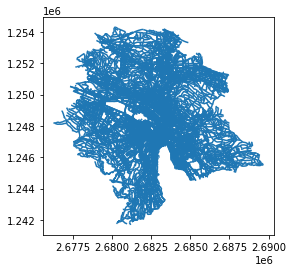

In [28]:
VeloWege.plot()
VeloWege.head()


<AxesSubplot:>

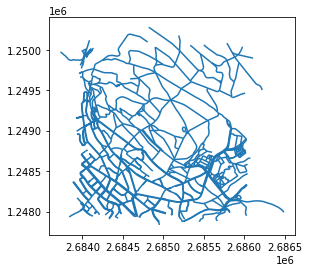

In [20]:
VeloWege_sub = VeloWege.cx[2684000:2686000, 1248000:1250000]
VeloWege_sub.plot()


,AccidentUID,AccidentType,AccidentType_de,AccidentType_fr,AccidentType_it,AccidentType_en,AccidentSeverityCategory,AccidentSeverityCategory_de,AccidentSeverityCategory_fr,AccidentSeverityCategory_it,...,AccidentMonth_it,AccidentMonth_en,AccidentWeekDay,AccidentWeekDay_de,AccidentWeekDay_fr,AccidentWeekDay_it,AccidentWeekDay_en,AccidentHour,AccidentHour_text,geometry
0,A2D2677533867004E0430A865E337004,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as4,Unfall mit Sachschaden,accident avec dommages matériels,Incidente con danni materiali,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,0.0,00h-01h,POINT (2684605.000 1245194.000)
1,9FD6441F802C20A6E0430A865E3320A6,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,1.0,01h-02h,POINT (2682382.000 1246980.000)
2,9FDA0DC4856A6094E0430A865E336094,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as4,Unfall mit Sachschaden,accident avec dommages matériels,Incidente con danni materiali,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,2.0,02h-03h,POINT (2682791.000 1247749.000)
3,A3B66E42396E6000E0430A865E336000,at5,Überqueren der Fahrbahn,accident en traversant une route,Incidente nell'attraversare la carreggiata,Accident when crossing the lane(s),as3,Unfall mit Leichtverletzten,accident avec blessés légers,Incidente con feriti leggeri,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,2.0,02h-03h,POINT (2681199.000 1247102.000)
4,9FDA0DBE8CCE9096E0430A865E339096,at0,Schleuder- oder Selbstunfall,dérapage ou perte de maîtrise,Incidente di sbandamento o per colpa propria,Accident with skidding or self-accident,as4,Unfall mit Sachschaden,accident avec dommages matériels,Incidente con danni materiali,...,Gennaio,January,aw406,Samstag,samedi,Sabato,Saturday,3.0,03h-04h,POINT (2682479.000 1250690.000)


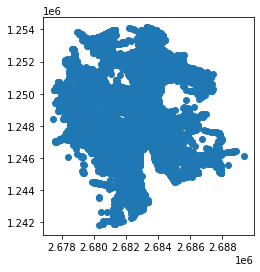

In [26]:
Unfaelle.plot()
Unfaelle.head()

<AxesSubplot:>

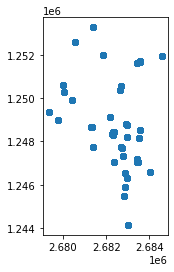

In [183]:
Zaehlungen.plot()


In [146]:
Zaehlungen.head()

,FK_ZAEHLER,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,FUSS_IN,FUSS_OUT,OST,NORD,geometry
0,U15G3063865,1357,2021-01-01T00:00,NaN,NaN,20.0,0.0,2682973,1246329,POINT (2682973.000 1246329.000)
1,ECO09113499,3927,2021-01-01T00:00,0.0,3.0,NaN,NaN,2682873,1245891,POINT (2682873.000 1245891.000)
2,U15G3063867,1358,2021-01-01T00:00,NaN,NaN,4.0,1.0,2683557,1251702,POINT (2683557.000 1251702.000)
3,U15G3063869,3011,2021-01-01T00:00,NaN,NaN,0.0,5.0,2682978,1248744,POINT (2682978.000 1248744.000)
4,YSH18065716,3279,2021-01-01T00:00,NaN,NaN,9.0,4.0,2683437,1247199,POINT (2683437.000 1247199.000)


In [178]:
# Drop Collums die wir nicht brauchen 
Zaehlungen = Zaehlungen.drop(["FUSS_IN", "FUSS_OUT"], axis = 1)


In [182]:
# Aggregiert Daten auf eine Zählung pro Stunde. Daten von einzelner Zählstation werden noch nicht wieder zusammengefügt. Koordinaten können nicht behalten werden,
# können aber über den Standort wieder eingefügt werden.
def aggregation(inp):
    list_stations = inp.FK_STANDORT.unique()

    for standort in list_stations:
        station = Zaehlungen.loc[Zaehlungen["FK_STANDORT"] == standort]
        station["Date_Hour"] = station["DATUM"].astype(str).str[:13]
        grouped = station.groupby("Date_Hour").agg({"FK_STANDORT": min, "VELO_IN": sum, "VELO_OUT": sum})
        
        return grouped

aggregation(Zaehlungen).head()
#print(aggregation(Zaehlungen))

/opt/miniconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,FK_STANDORT,VELO_IN,VELO_OUT
Date_Hour,,,
2021-01-01T00,1357,0.0,0.0
2021-01-01T01,1357,0.0,0.0
2021-01-01T02,1357,0.0,0.0
2021-01-01T03,1357,0.0,0.0
2021-01-01T04,1357,0.0,0.0


1: First, we will conduct an EDA on all three data-sets to get a feeling for the data

2: We segment the bicycle path network into nodes and edges

3: Then all accidents get attributed to the spatially closest edge
Accidents get also attributed by severity of the accident (categories already set by raw data)

4: Then, accidents normalized by the closest (determined via Voronoi tessellation) counting station value. 
The resulting graph of safety-weighted edges has an x, y and t (Lat, Long and Daytime) dimension. 

5: We will then use this graph to train a model (Maybe SVM, GCN or we will see what the lecture brings us).
The model should then be capable to predict the safety of any rout at any time in Zurich

BONUS:

If time allows it, we will also introduce the following features:
Weather data (to introduce an additional dimension, like dry, wet & frozen)
Topography (to introduce an additional weighting criteria: steepness of the segments) 
Connect our model to an actual routing engine (which uses travel time for costing of the edges)

3: Then all accidents get attributed to the spatially closest edge
Accidents get also attributed by severity of the accident (categories already set by raw data)


In [156]:
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import itertools
from operator import itemgetter


